In [2]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import G2Net2022Dataset
from transforms import *
import albumentations as A

In [6]:
model_path = Path('results_221129/aug_18/')

In [7]:
# submission_path = model_path/'predictions.npy'
submission_path = model_path/'predictions_tta.npy'
predictions = sigmoid(np.load(submission_path))
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
public748 = pd.read_csv('input/public748.csv')
public716 = pd.read_csv('input/public716.csv')

In [8]:
# test['target'] = predictions.reshape(-1) * 0.15 + public748['target'].values * 0.8 + public716['target'].values * 0.15
test['target'] = predictions.reshape(-1)
# test['target'] = predictions[0]

In [9]:
test

id    target
0     00054c878  0.140588
1     0007285a3  0.918475
2     00076c5a6  0.144578
3     001349290  0.150186
4     001a52e92  0.167093
...         ...       ...
7970  ffbce04ef  0.970505
7971  ffc2d976b  0.133999
7972  ffc905909  0.134329
7973  ffe276f3e  0.156536
7974  fffa17f67  0.160657

[7975 rows x 2 columns]

In [17]:
test.to_csv(model_path/'submission.csv', index=False)
# test.to_csv(model_path/'blend_submission.csv', index=False)

# Correlation

In [22]:
model_paths = [
    Path('results_221129/aug_15_bu/'), # 733
    Path('results_221129/aug_11_ds1/'), # 723
    Path('results_221129/aug_11/'), # 719
]

In [23]:
prediction_df = {}
for p in model_paths:
    prediction_df[p.stem] = sigmoid(np.load(p/'predictions_tta.npy')).reshape(-1)
prediction_df = pd.DataFrame(prediction_df)
prediction_df['public748'] = public748['target'].values
prediction_df['public716'] = public716['target'].values

In [24]:
prediction_df

aug_15_bu  aug_11_ds1    aug_11  public748  public716
0      0.191785    0.433246  0.404649   0.077132   0.657053
1      0.845426    0.937696  0.796115   0.848641   0.768253
2      0.200898    0.520899  0.277761   0.106932   0.473940
3      0.177436    0.510110  0.232579   0.256063   0.398179
4      0.297629    0.466612  0.365187   0.507310   0.489631
...         ...         ...       ...        ...        ...
7970   0.985032    0.985947  0.995467   0.937471   0.865461
7971   0.244745    0.470688  0.249129   0.088365   0.585368
7972   0.179091    0.365641  0.184932   0.081671   0.452188
7973   0.238882    0.649633  0.428527   0.112314   0.571307
7974   0.203473    0.538380  0.234376   0.103874   0.558843

[7975 rows x 5 columns]

<AxesSubplot:>

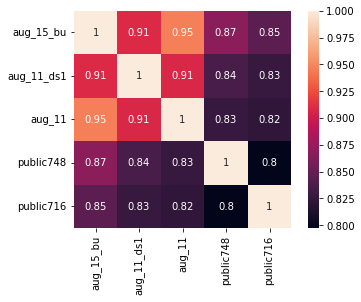

In [25]:
sns.heatmap(prediction_df.corr(), square=True, annot=True)

# Error analysis

In [26]:
prediction_df['rank_std'] = prediction_df.rank(0).std(1)

<AxesSubplot:xlabel='rank_std', ylabel='Count'>

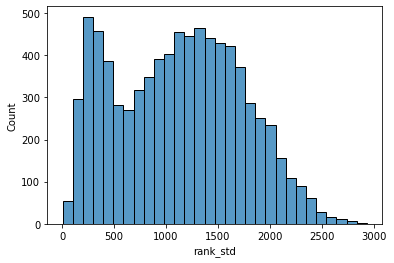

In [27]:
sns.histplot(prediction_df['rank_std'])

In [28]:
prediction_df = pd.concat([prediction_df, test], axis=1)

In [29]:
# prediction_df_easy = prediction_df.sort_values('rank_std')
# ds = G2Net2022Dataset(
#     prediction_df_easy.head(10),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     resize_factor=16,
#     normalize='local'
# )
# for idx in range(10):
#     specs = ds[idx][0]
#     labels = prediction_df_easy.iloc[idx][['model1', 'model2', 'model3']]
#     plt.figure(figsize=(8, 6))
#     plt.suptitle(f'{labels}')
#     plt.subplot(1, 2, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.subplot(1, 2, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.show()


In [30]:
prediction_df

aug_15_bu  aug_11_ds1    aug_11  public748  public716     rank_std  \
0      0.191785    0.433246  0.404649   0.077132   0.657053  2463.928814   
1      0.845426    0.937696  0.796115   0.848641   0.768253   169.489528   
2      0.200898    0.520899  0.277761   0.106932   0.473940  1229.051179   
3      0.177436    0.510110  0.232579   0.256063   0.398179  1850.767679   
4      0.297629    0.466612  0.365187   0.507310   0.489631  1499.022615   
...         ...         ...       ...        ...        ...          ...   
7970   0.985032    0.985947  0.995467   0.937471   0.865461   121.781772   
7971   0.244745    0.470688  0.249129   0.088365   0.585368  1670.901463   
7972   0.179091    0.365641  0.184932   0.081671   0.452188   846.836761   
7973   0.238882    0.649633  0.428527   0.112314   0.571307  1581.126402   
7974   0.203473    0.538380  0.234376   0.103874   0.558843  1182.179893   

             id    target  
0     00054c878  0.140588  
1     0007285a3  0.918475  
2     00076c5a6  0.144578  
3     001349290  0.150186  
4     001a52e92  0.167093  
...         ...       ...  
7970  ffbce04ef  0.970505  
7971  ffc2d976b  0.133999  
7972  ffc905909  0.134329  
7973  ffe276f3e  0.156536  
7974  fffa17f67  0.160657  

[7975 rows x 8 columns]

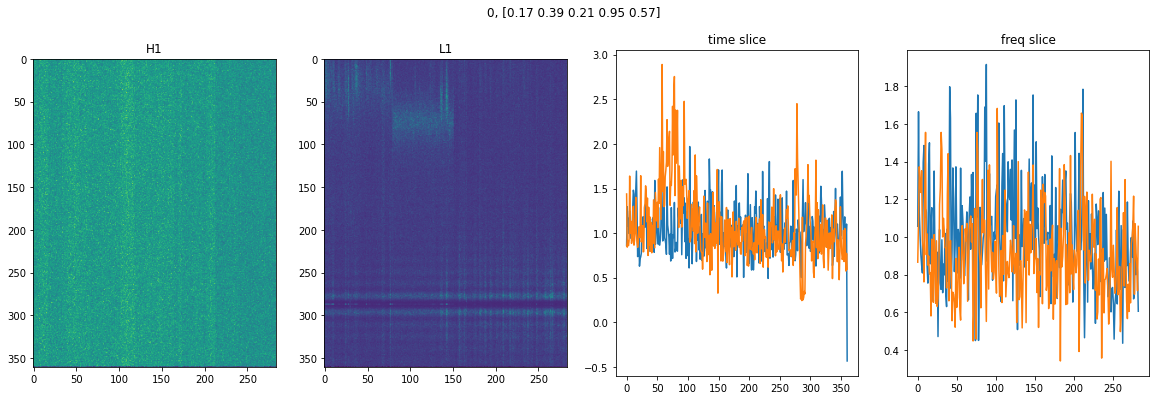

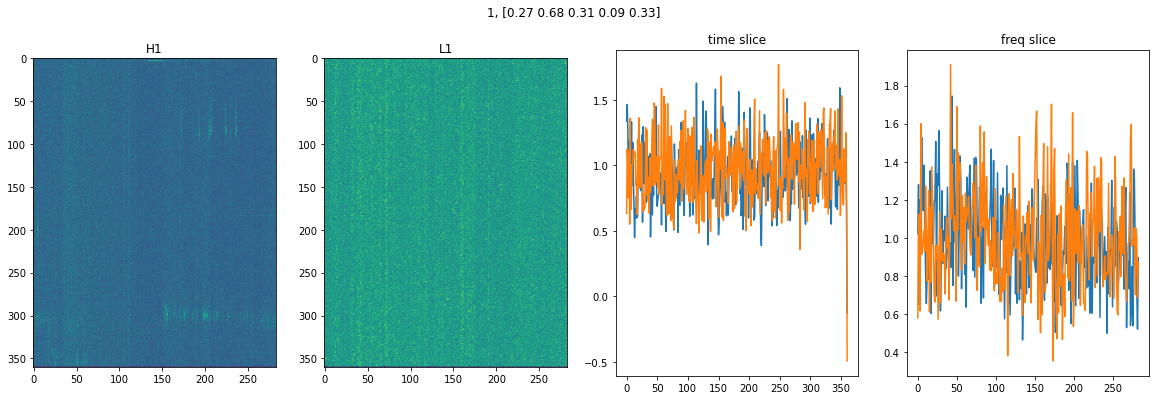

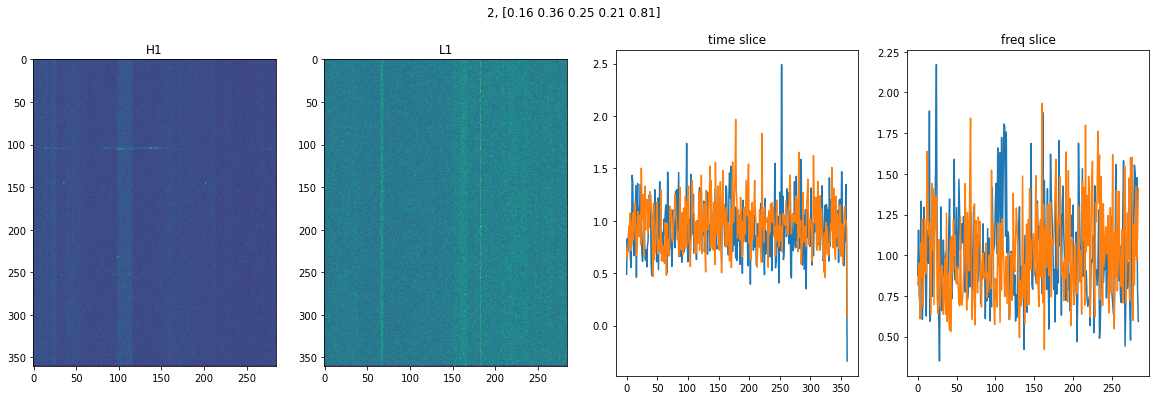

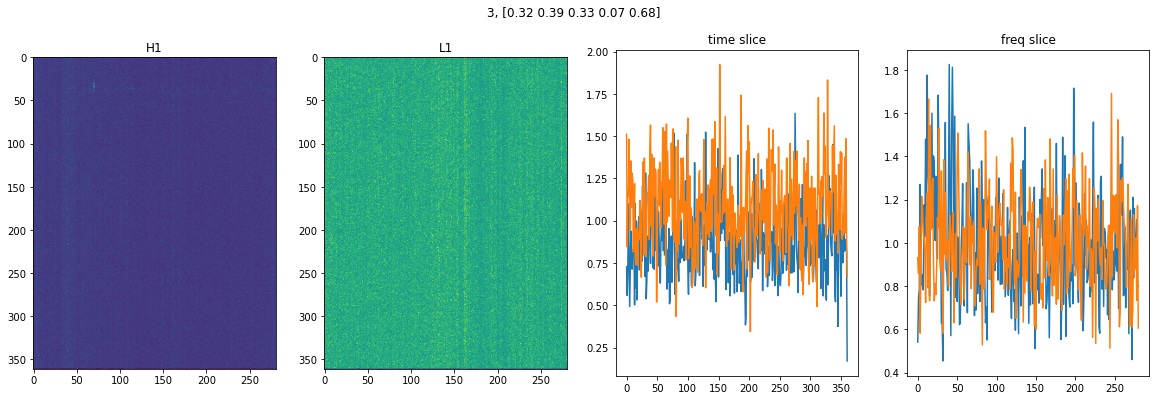

In [38]:
prediction_df_hard = prediction_df.sort_values('rank_std', ascending=False)
ds = G2Net2022Dataset(
    # prediction_df_hard.head(20),
    prediction_df.loc[prediction_df['id'].isin(["040b35321", "09d7ea37a", "081ee0aea", "025517630"])],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    resize_factor=16,
    normalize='global',
    spec_diff=True,
    # transforms=ClipSignal(0, 1)
    # transforms=BandNoise(p=1.0)
    # transforms=DeltaNoise(channel='both', strength=(500, 4000), p=1),
    # transforms=MixupChannel(fix_area=True, p=1),
    # transforms=MixupChannel2(256, p=1)
)
for idx, (specs, _) in enumerate(ds):
    labels = prediction_df_hard.drop(['id', 'rank_std', 'target'], axis=1).iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    plt.plot(specs[:, 128, 0])
    plt.plot(specs[:, 128, 1])
    plt.title('time slice')
    plt.subplot(1, 4, 4)
    plt.plot(specs[180, :, 0])
    plt.plot(specs[180, :, 1])
    plt.title('freq slice')
    plt.show()

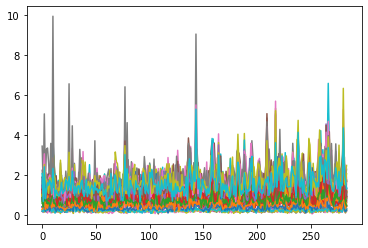

In [43]:
error_spec = ds[0][0][:, :, 1]
for i in np.arange(250, 300):
    plt.plot(error_spec[i, :])
plt.show()

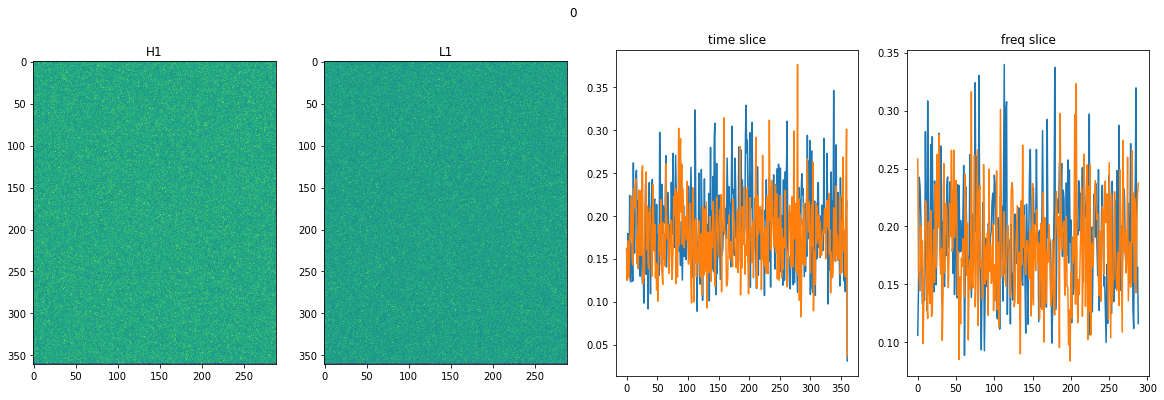

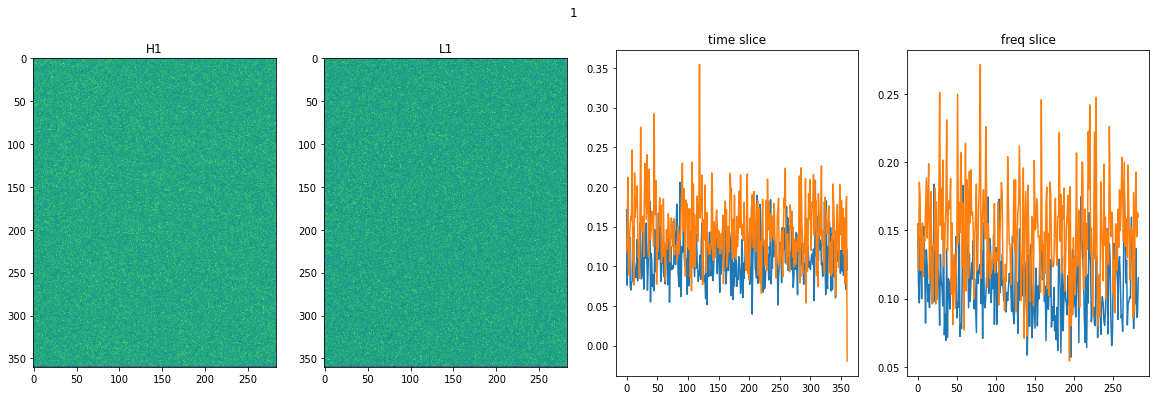

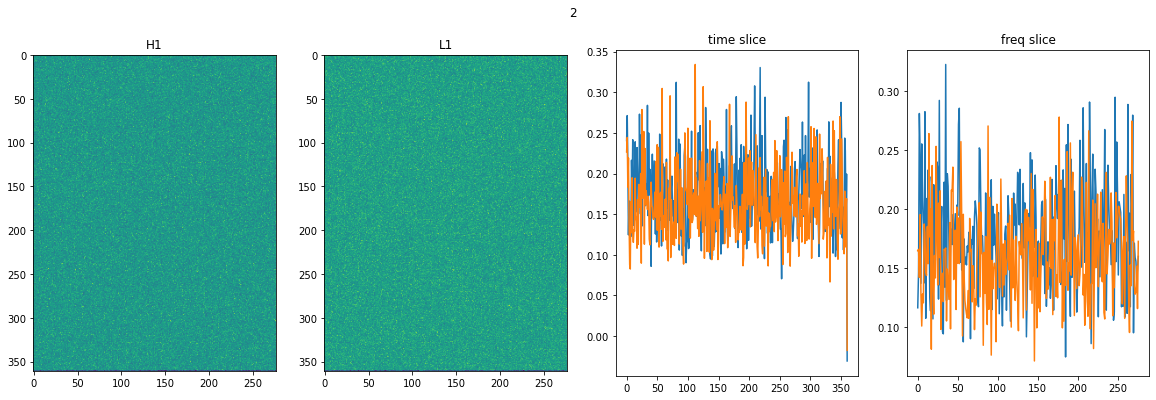

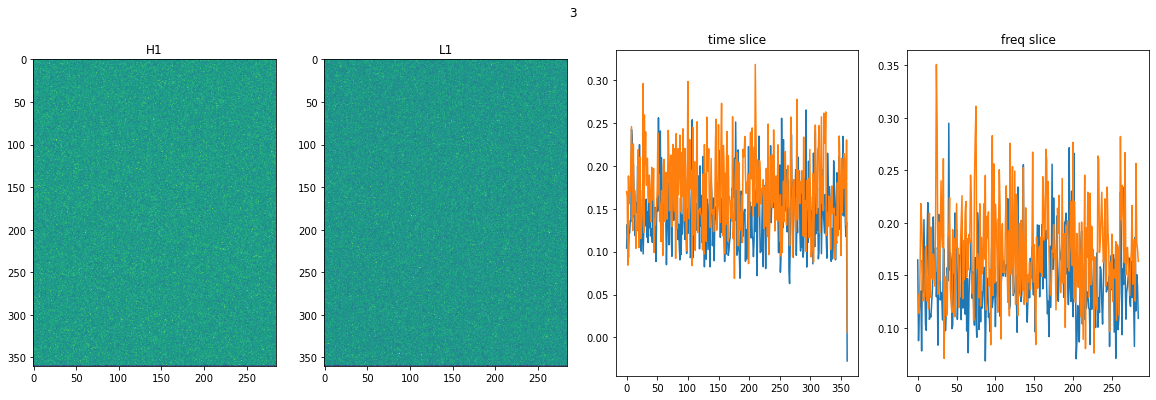

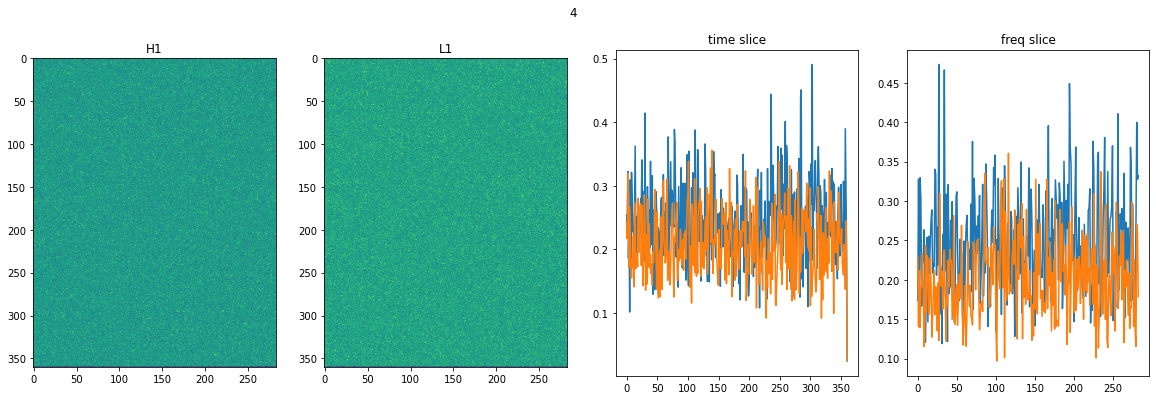

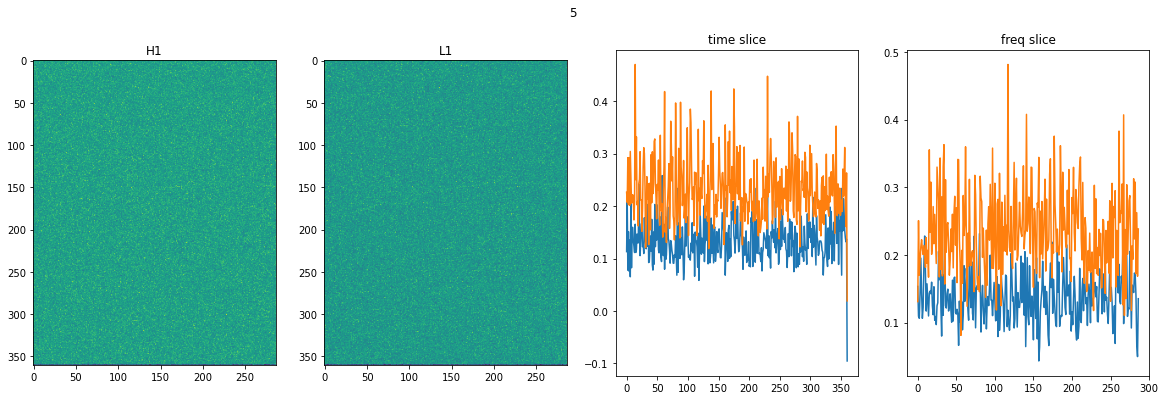

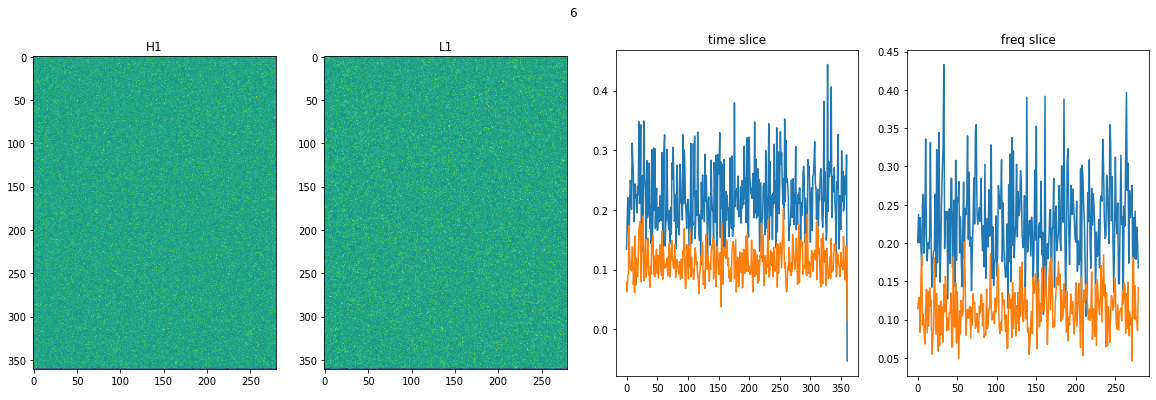

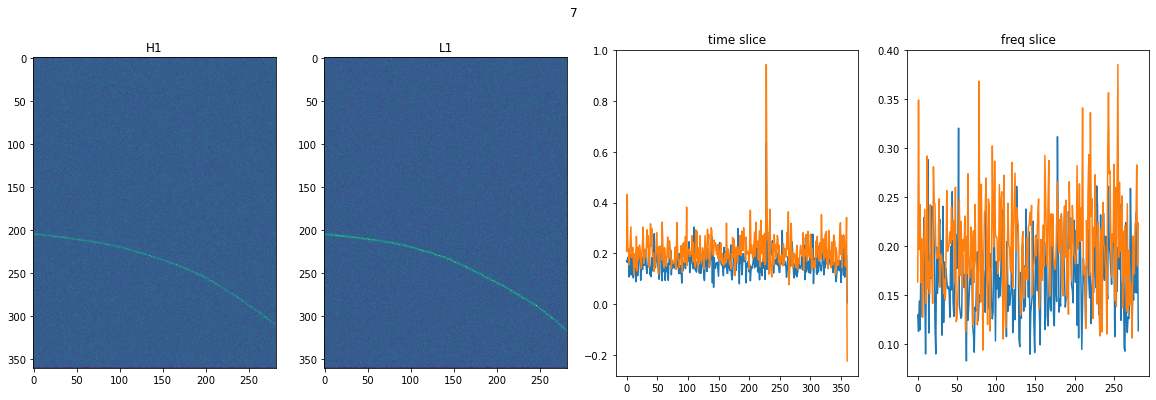

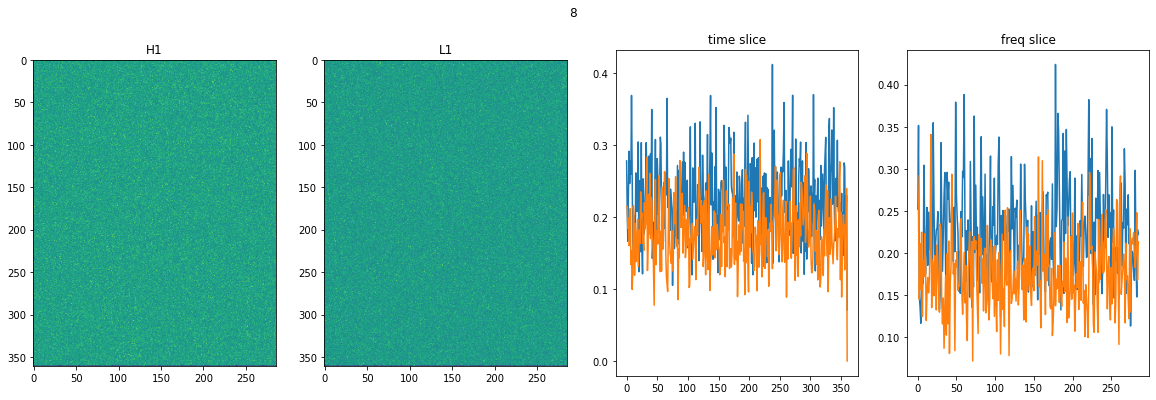

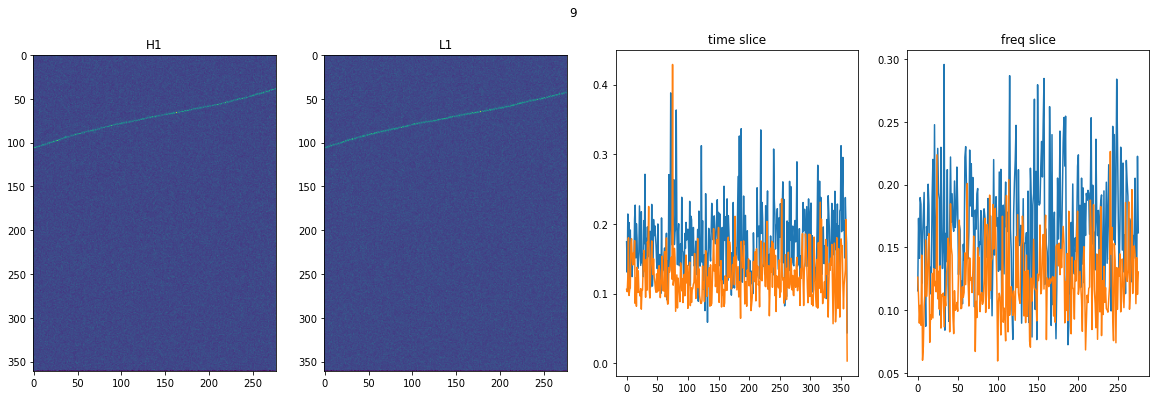

In [47]:
ds = G2Net2022Dataset(
    pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v7.csv').head(10),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v7'),
    resize_factor=16,
    normalize='global',
    spec_diff=True,
    # transforms=ClipSignal(0, 1)
    # transforms=BandNoise(p=1.0)
    # transforms=DeltaNoise(channel='both', strength=(500, 4000), p=1),
    # transforms=MixupChannel(fix_area=True, p=1),
    # transforms=MixupChannel2(256, p=1)
)
for idx, (specs, _) in enumerate(ds):
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    plt.plot(specs[:, 128, 0])
    plt.plot(specs[:, 128, 1])
    plt.title('time slice')
    plt.subplot(1, 4, 4)
    plt.plot(specs[180, :, 0])
    plt.plot(specs[180, :, 1])
    plt.title('freq slice')
    plt.show()